In [159]:
import os
import torch
import numpy as np
from PIL import Image
from nuscenes.utils.data_classes import LidarPointCloud
from nuscenes.utils.geometry_utils import view_points
from nuscenes.nuscenes import NuScenes
from pyquaternion import Quaternion
import matplotlib.pyplot as plt
from scipy.interpolate import griddata, LinearNDInterpolator
from scipy.spatial import Delaunay

In [160]:
from core.occlusion_detector.occlusion_detector import occlusion_detector
nusc = NuScenes(version='v1.0-mini', dataroot='/scratch1/ganesang/nuScenes/mini/', verbose=True)
sample = nusc.sample[15]

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.734 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [161]:
def rotation_matrix(theta_x, theta_y, theta_z):
    theta_x = (np.pi/180)*theta_x
    theta_y = (np.pi/180)*theta_y
    theta_z = (np.pi/180)*theta_z
    Rx = np.array([[1, 0, 0],
               [0, np.cos(theta_x), -np.sin(theta_x)],
               [0, np.sin(theta_x), np.cos(theta_x)]])
    Ry = np.array([[np.cos(theta_y), 0, np.sin(theta_y)],
                [0, 1, 0],
                [-np.sin(theta_y), 0, np.cos(theta_y)]])
    Rz = np.array([[np.cos(theta_z), -np.sin(theta_z), 0],
                [np.sin(theta_z), np.cos(theta_z), 0],
                [0, 0, 1]])
    
    R = Rx@Ry@Rz

    return R

In [162]:
def geometric_transformation(rotation, translation):
    mat = np.eye(4)
    mat[:3, :3] = rotation
    mat[:3, 3] = translation
    return mat

In [163]:
sample_token = sample['token']
camera_channel = 'CAM_FRONT'
    
sample = nusc.get('sample', sample_token)
lidar_token = sample['data']['LIDAR_TOP']
camera_token = sample['data'][camera_channel]

lidar = nusc.get('sample_data', lidar_token)
cam = nusc.get('sample_data', camera_token)
pcl_path = os.path.join(nusc.dataroot, lidar['filename'])
pc = LidarPointCloud.from_file(pcl_path)
im = Image.open(os.path.join(nusc.dataroot, cam['filename']))

cam_loc_rot_ang = {'CAM_FRONT': 0,
                'CAM_FRONT_RIGHT': -55,
                'CAM_FRONT_LEFT': 55,
                'CAM_BACK': 180,
                'CAM_BACK_RIGHT': -110,
                'CAM_BACK_LEFT': 110}
R_lidar_to_cam = rotation_matrix(90, 0, 0)
R_cam_ang = rotation_matrix(0, cam_loc_rot_ang[camera_channel], 0)
pc.rotate(R_lidar_to_cam)
pc.rotate(R_cam_ang)

cs_record_lidar = nusc.get('calibrated_sensor', lidar['calibrated_sensor_token'])
cs_record_cam = nusc.get('calibrated_sensor', cam['calibrated_sensor_token'])
poserecord_lidar = nusc.get('ego_pose', lidar['ego_pose_token'])
poserecord_cam = nusc.get('ego_pose', cam['ego_pose_token'])

cam_intrinsic = np.array(cs_record_cam['camera_intrinsic'])

lidar_to_veh_rot = Quaternion(cs_record_lidar['rotation']).rotation_matrix
lidar_to_veh_trans = np.array(cs_record_lidar['translation'])
lidar_to_veh_mat = geometric_transformation(lidar_to_veh_rot, lidar_to_veh_trans)

cam_to_veh_rot = Quaternion(cs_record_cam['rotation']).rotation_matrix
cam_to_veh_trans = np.array(cs_record_cam['translation'])
cam_to_veh_mat = geometric_transformation(cam_to_veh_rot, cam_to_veh_trans)

veh_to_glb_lidar_rot = Quaternion(poserecord_lidar['rotation']).rotation_matrix
veh_to_glb_lidar_trans = np.array(poserecord_lidar['translation'])
veh_to_glb_lidar_mat = geometric_transformation(veh_to_glb_lidar_rot, veh_to_glb_lidar_trans)

veh_to_glb_cam_rot = Quaternion(poserecord_cam['rotation']).rotation_matrix
veh_to_glb_cam_trans = np.array(poserecord_cam['translation'])
veh_to_glb_cam_mat = geometric_transformation(veh_to_glb_cam_rot, veh_to_glb_cam_trans)

#Relative pose from lidar to rgb camera
# relative_pose = lidar_to_veh_mat @ veh_to_glb_lidar_mat @ np.linalg.inv(veh_to_glb_cam_mat) @ np.linalg.inv(cam_to_veh_mat)
relative_pose = np.linalg.inv(cam_to_veh_mat) @ np.linalg.inv(veh_to_glb_cam_mat) @ veh_to_glb_lidar_mat @ lidar_to_veh_mat
#Undo lidar to camera rotation operations
relative_pose = relative_pose  @ geometric_transformation(R_cam_ang, 0).T @ geometric_transformation(R_lidar_to_cam, 0).T

cs_record = nusc.get('calibrated_sensor', cam['calibrated_sensor_token'])
depths = pc.points[2, :]
coloring = depths
points = view_points(pc.points[:3, :], np.array(cs_record['camera_intrinsic']), normalize=True)

min_dist = 1.0
mask = np.ones(depths.shape[0], dtype=bool)
mask = np.logical_and(mask, depths > min_dist)
mask = np.logical_and(mask, points[0, :] > 1)
mask = np.logical_and(mask, points[0, :] < im.size[0] - 1)
mask = np.logical_and(mask, points[1, :] > 1)
mask = np.logical_and(mask, points[1, :] < im.size[1] - 1)
points = points[:, mask]
coloring = coloring[mask]

# dot_size = 5
# fig, ax = plt.subplots(1, 1, figsize=(9, 16))
# ax.imshow(im)
# plot = ax.scatter(points[0, :], points[1, :], c=coloring, s=dot_size)
# im_ratio = im.size[1]/im.size[0]
# fig.colorbar(plot, ax=ax, fraction=0.046*im_ratio, pad=0.04)
# ax.axis('off')
depth = coloring

In [166]:
grid_x, grid_y = np.meshgrid(range(1600),range(900))
tri = Delaunay(points[:2,:].T)
interp_De = LinearNDInterpolator(tri, depth, fill_value=1e2)
intrp_d = interp_De(grid_x, grid_y)

In [167]:
intrinsic = torch.eye(4, dtype=torch.float32).cuda()[None,:,:]
intrinsic[:,:3,:3] = torch.tensor(cam_intrinsic, dtype=torch.float32).cuda()
#LiDAR to RGB
pose = torch.tensor(np.linalg.inv(relative_pose)[None,:,:], dtype=torch.float32).cuda()
depthmap = torch.tensor(intrp_d[None,None,:,:], dtype=torch.float32).cuda()
occ_map = occlusion_detector.apply(intrinsic, pose, depthmap,1000)

In [169]:
bz, _, h, w = depthmap.shape #Lidar Plane

minsr_dist = 1
pose_pr = torch.clone(pose)
pose_pr[:, 0:3, 3] = 0

cam_org_3d = torch.zeros([bz, 4, 1], device=depthmap.device, dtype=torch.float32)
cam_org_3d[:, 3, :] = 1
epp1 = intrinsic @ torch.inverse(pose) @ cam_org_3d  # Epipole on frame 1, projection of camera 2
epp1[:, 0, 0] = epp1[:, 0, 0] / epp1[:, 2, 0]
epp1[:, 1, 0] = epp1[:, 1, 0] / epp1[:, 2, 0]
epp1 = epp1[:, 0:2, 0]
epp2 = intrinsic @ pose @ cam_org_3d  # Epipole on frame 2, projection of camera 1
epp2[:, 0, 0] = epp2[:, 0, 0] / epp2[:, 2, 0]
epp2[:, 1, 0] = epp2[:, 1, 0] / epp2[:, 2, 0]
epp2 = epp2[:, 0:2, 0]

xx, yy = np.meshgrid(range(w), range(h), indexing='xy')
xx = torch.from_numpy(xx).view([1, h, w, 1, 1]).expand([bz, -1, -1, -1, -1]).float().cuda(depthmap.device)
yy = torch.from_numpy(yy).view([1, h, w, 1, 1]).expand([bz, -1, -1, -1, -1]).float().cuda(depthmap.device)
ones = torch.ones_like(xx)
depthmap_rs = depthmap.squeeze(1).unsqueeze(-1).unsqueeze(-1)
pts3d_v1_batch = torch.cat([xx * depthmap_rs, yy * depthmap_rs, depthmap_rs, ones], axis=3)#LidarPlane
pts2d_v1_batch = torch.cat([xx, yy], axis=3).squeeze(-1)

pM1 = intrinsic @ torch.inverse(pose) @ torch.inverse(intrinsic)
pM1 = pM1.view([bz, 1, 1, 4, 4]).expand([-1, h, w, -1, -1])
pts3d_v2_batch = pM1 @ pts3d_v1_batch#Lidar to RGB
pts2d_v2_batch = torch.clone(pts3d_v2_batch)
pts2d_v2_batch[:, :, :, 0, 0] = pts2d_v2_batch[:, :, :, 0, 0] / pts2d_v2_batch[:, :, :, 2, 0]
pts2d_v2_batch[:, :, :, 1, 0] = pts2d_v2_batch[:, :, :, 1, 0] / pts2d_v2_batch[:, :, :, 2, 0]
pts2d_v2_batch = pts2d_v2_batch[:, :, :, 0:2, 0]
out_range_selecor = (pts3d_v2_batch[:, :, :, 2, 0] >= 0) * (pts2d_v2_batch[:, :, :, 0] >= 0) * (pts2d_v2_batch[:, :, :, 0] <= w - 1) * (pts2d_v2_batch[:, :, :, 1] >= 0) * (pts2d_v2_batch[:, :, :, 1] <= h - 1)
out_range_selecor = (out_range_selecor == 0)
occ_selector = torch.clone(out_range_selecor).unsqueeze(1)

pM2 = intrinsic @ torch.inverse(pose_pr) @ torch.inverse(intrinsic) @ intrinsic @ pose @ torch.inverse(intrinsic)
pM2 = pM2.view([bz, 1, 1, 4, 4]).expand([-1, h, w, -1, -1])
pts2dsrch_v1_batch = pM2 @ pts3d_v1_batch#Lidar_inf to RGB
pts2dsrch_v1_batch[:, :, :, 0, 0] = pts2dsrch_v1_batch[:, :, :, 0, 0] / pts2dsrch_v1_batch[:, :, :, 2, 0]
pts2dsrch_v1_batch[:, :, :, 1, 0] = pts2dsrch_v1_batch[:, :, :, 1, 0] / pts2dsrch_v1_batch[:, :, :, 2, 0]
pts2dsrch_v1_batch = pts2dsrch_v1_batch[:, :, :, 0:2, 0]

srh_distance = torch.sqrt(torch.sum((pts2dsrch_v1_batch - pts2d_v1_batch) ** 2 + 1e-10, axis=3))

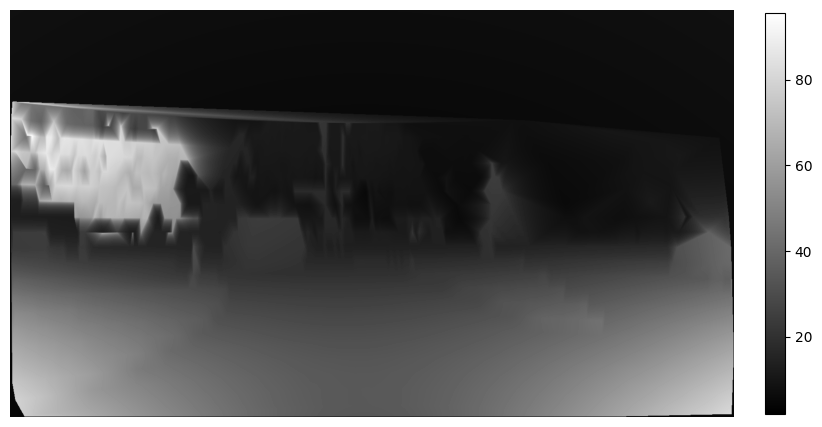

In [172]:
plt.figure(figsize=(10,10))
plt.imshow(srh_distance[0].to('cpu'), cmap='gray')
plt.axis('off')
im_ratio = srh_distance[0].shape[0]/srh_distance[0].shape[1]
plt.colorbar(fraction=0.046*im_ratio, pad=0.04)

# Visualization

In [180]:
def render_virtual_plane(sample_token, camera_channel='CAM_FRONT'):
    sample = nusc.get('sample', sample_token)
    lidar_token = sample['data']['LIDAR_TOP']
    camera_token = sample['data'][camera_channel]

    lidar = nusc.get('sample_data', lidar_token)
    cam = nusc.get('sample_data', camera_token)
    pcl_path = os.path.join(nusc.dataroot, lidar['filename'])
    pc = LidarPointCloud.from_file(pcl_path)
    im = Image.open(os.path.join(nusc.dataroot, cam['filename']))

    cam_loc_rot_ang = {'CAM_FRONT': 0,
                   'CAM_FRONT_RIGHT': -55,
                   'CAM_FRONT_LEFT': 55,
                   'CAM_BACK': 180,
                   'CAM_BACK_RIGHT': -110,
                   'CAM_BACK_LEFT': 110}
    R_lidar_to_cam = rotation_matrix(90, 0, 0)
    R_cam_ang = rotation_matrix(0, cam_loc_rot_ang[camera_channel], 0)
    pc.rotate(R_lidar_to_cam)
    pc.rotate(R_cam_ang)
    
    cs_record_lidar = nusc.get('calibrated_sensor', lidar['calibrated_sensor_token'])
    cs_record_cam = nusc.get('calibrated_sensor', cam['calibrated_sensor_token'])
    poserecord_lidar = nusc.get('ego_pose', lidar['ego_pose_token'])
    poserecord_cam = nusc.get('ego_pose', cam['ego_pose_token'])

    cam_intrinsic = np.array(cs_record_cam['camera_intrinsic'])

    lidar_to_veh_rot = Quaternion(cs_record_lidar['rotation']).rotation_matrix
    lidar_to_veh_trans = np.array(cs_record_lidar['translation'])
    lidar_to_veh_mat = geometric_transformation(lidar_to_veh_rot, lidar_to_veh_trans)

    cam_to_veh_rot = Quaternion(cs_record_cam['rotation']).rotation_matrix
    cam_to_veh_trans = np.array(cs_record_cam['translation'])
    cam_to_veh_mat = geometric_transformation(cam_to_veh_rot, cam_to_veh_trans)
    
    veh_to_glb_lidar_rot = Quaternion(poserecord_lidar['rotation']).rotation_matrix
    veh_to_glb_lidar_trans = np.array(poserecord_lidar['translation'])
    veh_to_glb_lidar_mat = geometric_transformation(veh_to_glb_lidar_rot, veh_to_glb_lidar_trans)

    veh_to_glb_cam_rot = Quaternion(poserecord_cam['rotation']).rotation_matrix
    veh_to_glb_cam_trans = np.array(poserecord_cam['translation'])
    veh_to_glb_cam_mat = geometric_transformation(veh_to_glb_cam_rot, veh_to_glb_cam_trans)

    #Relative pose from lidar to rgb camera
    relative_pose1 = np.linalg.inv(cam_to_veh_mat) @ np.linalg.inv(veh_to_glb_cam_mat) @ veh_to_glb_lidar_mat @ lidar_to_veh_mat
    #Undo lidar to camera rotation operations
    relative_pose = relative_pose1  @ geometric_transformation(R_cam_ang, 0).T @ geometric_transformation(R_lidar_to_cam, 0).T
    
    cs_record = nusc.get('calibrated_sensor', cam['calibrated_sensor_token'])
    depths = pc.points[2, :]
    coloring = depths
    points = view_points(pc.points[:3, :], np.array(cs_record['camera_intrinsic']), normalize=True)
    
    pc.transform(relative_pose)
    depths2 = pc.points[2, :]
    coloring2 = depths2
    points2 = view_points(pc.points[:3, :], np.array(cs_record['camera_intrinsic']), normalize=True)
    
    min_dist = 1.0
    mask = np.ones(depths.shape[0], dtype=bool)
    mask = np.logical_and(mask, depths > min_dist)
    mask = np.logical_and(mask, points[0, :] > 1)
    mask = np.logical_and(mask, points[0, :] < im.size[0] - 1)
    mask = np.logical_and(mask, points[1, :] > 1)
    mask = np.logical_and(mask, points[1, :] < im.size[1] - 1)
    points = points[:, mask]
    coloring = coloring[mask]

    min_dist = 1.0
    mask = np.ones(depths2.shape[0], dtype=bool)
    mask = np.logical_and(mask, depths2 > min_dist)
    mask = np.logical_and(mask, points2[0, :] > 1)
    mask = np.logical_and(mask, points2[0, :] < im.size[0] - 1)
    mask = np.logical_and(mask, points2[1, :] > 1)
    mask = np.logical_and(mask, points2[1, :] < im.size[1] - 1)
    points2 = points2[:, mask]
    coloring2 = coloring2[mask]

    # dot_size = 5
    # fig, ax = plt.subplots(1, 1, figsize=(9, 16))
    # ax.imshow(im)
    # plot = ax.scatter(points[0, :], points[1, :], c=coloring, s=dot_size)
    # im_ratio = im.size[1]/im.size[0]
    # fig.colorbar(plot, ax=ax, fraction=0.046*im_ratio, pad=0.04)
    # ax.axis('off')
    return points, coloring, points2, coloring2, relative_pose, cam_intrinsic, im

In [212]:
sample = nusc.sample[2]
points, coloring, points2, coloring2, relative_pose, cam_intrinsic, im = render_virtual_plane(sample['token'])

In [213]:
grid_x, grid_y = np.meshgrid(range(1600),range(900))
tri = Delaunay(points[:2,:].T)
interp_De = LinearNDInterpolator(tri, coloring, fill_value=1e2)
intrp_d = interp_De(grid_x, grid_y)

In [214]:
intrinsic = torch.eye(4, dtype=torch.float32).cuda()[None,:,:]
intrinsic[:,:3,:3] = torch.tensor(cam_intrinsic, dtype=torch.float32).cuda()
#LiDAR to RGB
pose = torch.tensor(np.linalg.inv(relative_pose)[None,:,:], dtype=torch.float32).cuda()
depthmap = torch.tensor(intrp_d[None,None,:,:], dtype=torch.float32).cuda()
occ_map = occlusion_detector.apply(intrinsic, pose, depthmap,10000)

(-0.5, 1599.5, 899.5, -0.5)

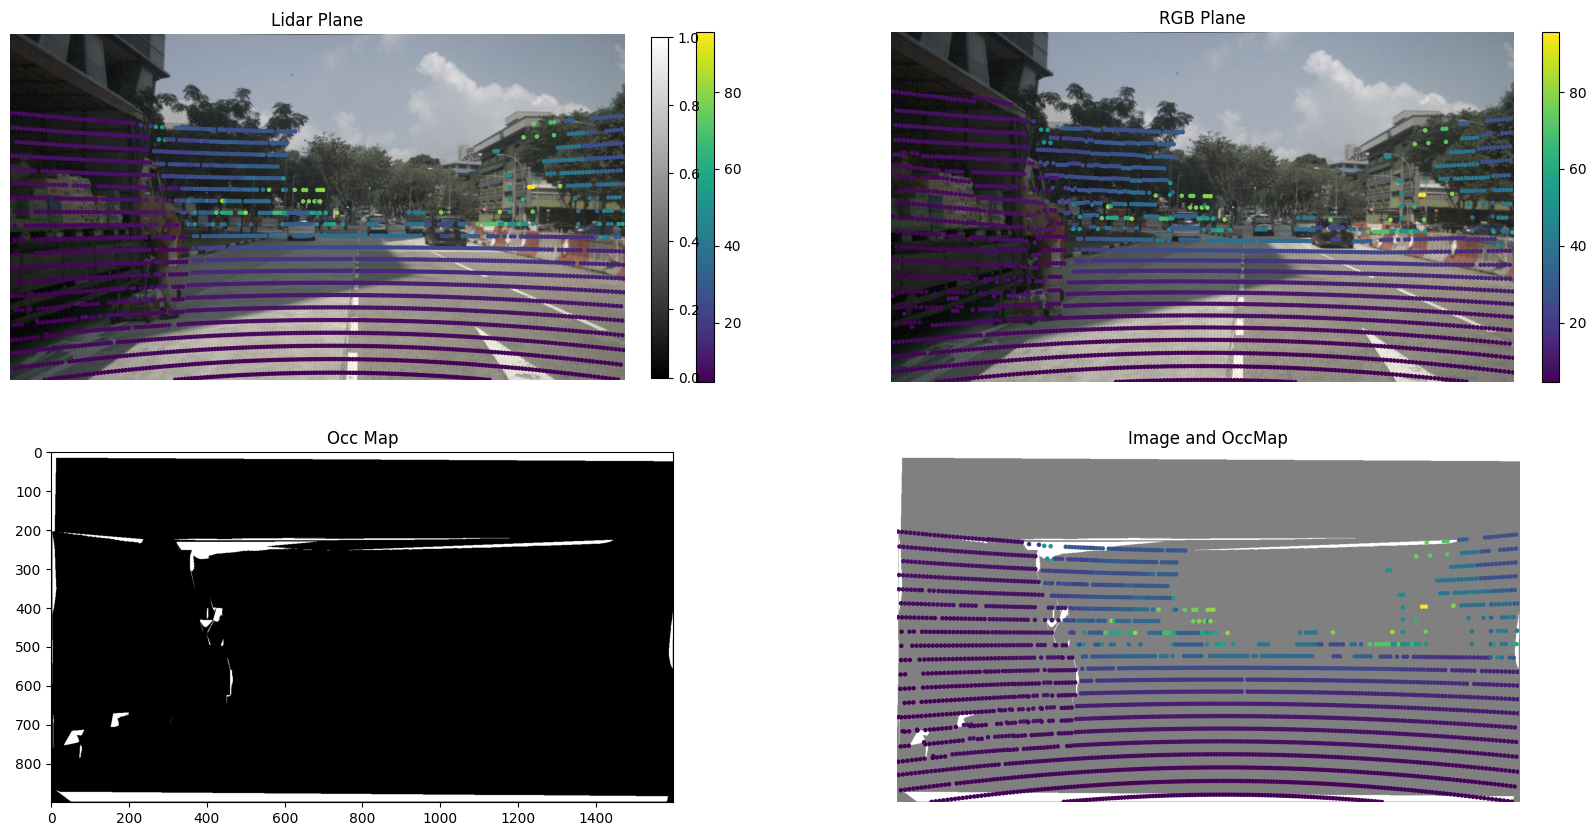

In [216]:
fig, ax = plt.subplots(2, 2, figsize=(20,10))
im_ratio = im.size[1]/im.size[0]

ax[0,0].set_title('Lidar Plane')
ax[0,0].imshow(im)
plot = ax[0,0].scatter(points[0, :], points[1, :], c=coloring, s=dot_size)
fig.colorbar(plot, ax=ax[0,0], fraction=0.046*im_ratio, pad=0.04)
ax[0,0].axis('off')

ax[0,1].set_title('RGB Plane')
ax[0,1].imshow(im)
plot = ax[0,1].scatter(points2[0, :], points2[1, :], c=coloring2, s=dot_size)
fig.colorbar(plot, ax=ax[0,1], fraction=0.046*im_ratio, pad=0.04)
ax[0,1].axis('off')

ax[1,0].set_title('Occ Map')
plot = ax[1,0].imshow(occ_map.squeeze().to('cpu'), cmap='gray')

ax[1,1].set_title('Image and OccMap')
ax[1,1].imshow(occ_map.squeeze().to('cpu'), cmap='gray', alpha=0.5)
ax[1,1].scatter(points[0, :], points[1, :], c=coloring, s=dot_size)
fig.colorbar(plot, ax=ax[0,0], fraction=0.046*im_ratio, pad=0.04)
ax[1,1].axis('off')